import matlab .mat file into python


In [3]:
from pylab import *
import matplotlib.tri as Tri
import matplotlib.pyplot as plt
%matplotlib notebook

#import tables
import h5py
import numpy as np
import numpy.matlib as ml
import numpy.linalg as la
import numpy.ma as ma

from central_ckv import central_ckv

/opt/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
# get the model in a matlab file, stored as -v7.3
# the model components must be saved as individual variables, 
# not as a struct.  See the matlab code structfields2vars
mf='temp3.mat';
#f = tables.openFile(mf, "r")
f = h5py.File(mf, "r")
print f

<HDF5 file "temp3.mat" (mode r)>


In [5]:
#print f.keys()
#for name in f:
#     print name
#print "P" in f

global c, k, Nd
global P, R, weights, index

c=np.squeeze(f['c'][:])
k=np.squeeze(f['k'][:])
Nd=np.squeeze(f['n_d'][:])
P=np.transpose(f['P'][:])
R=np.transpose(f['R'][:])
weights=np.squeeze(f['weights'][:])
index=np.squeeze(f['index'][:])
#xtest=np.squeeze(f['X'][:])
xtest=np.array([ 66.8, 1.06, 7.5, 38, 5.23, 5.25])
xtest=np.squeeze(np.transpose(xtest))

rmw=xtest[0]
H_b=xtest[1]
TS=xtest[2]
Vmax=xtest[3]
LatNorth=xtest[4]
LatSouth=xtest[5]
#rmw,H_b,TS,Vmax,LatNorth,LatSouth

p1min=np.min(P[:,0]); p1max=np.max(P[:,0])  # rmw
p2min=np.min(P[:,1]); p2max=np.max(P[:,1])  # H_b
p3min=np.min(P[:,2]); p3max=np.max(P[:,2])  # TS
p4min=np.min(P[:,3]); p4max=np.max(P[:,3])  # Vmax
p5min=np.min(P[:,4]); p5max=np.max(P[:,4])  # LatNorth
p6min=np.min(P[:,5]); p6max=np.max(P[:,5])  # LatSouth

dp1=(p1max-p1min)/20
dp2=(p2max-p2min)/20
dp3=(p3max-p3min)/20
dp4=(p4max-p4min)/20
dp5=(p5max-p5min)/20
dp6=(p6max-p6min)/20

# get the FEM grid parts from f to create a triangulation object
lon = np.squeeze(f['x'][:])
lat = np.squeeze(f['y'][:])
latmin = np.mean(lat)  # needed for scaling lon/lat plots
nv  = np.squeeze(f['e'][:,:] -1)
nv=np.transpose(nv)
tri = Tri.Triangulation(lon,lat, triangles=nv)

NodeIndices=np.squeeze(f['NodeIndices'][:])
NodeIndices=(NodeIndices-1).astype(int)

In [43]:
def master(rmw,H_b,TS,Vmax,LatNorth,LatSouth):
    
    global c, k, Nd
    global P, R, weights, index
    
    xtest=np.array([rmw,H_b,TS,Vmax,LatNorth,LatSouth])
    temp=central_ckv(P,R,c,k,weights,Nd,index,xtest)
    vmin=np.floor(np.nanmin(temp))
    vmax=np.ceil(np.nanmax(temp))
    
    # put response into variable sized as lon.shape
    zhat=ma.array(np.zeros(tri.x.shape))
    zhat[:]=zhat.fill_value
    zhat[NodeIndices]=temp

    vmin=np.floor(np.nanmin(temp))
    vmax=np.ceil(np.nanmax(temp))
    levels = linspace(vmin,vmax,11)

    #print 'Making contours in figure ...'
    fig = plt.figure(figsize=(4,3), dpi=144)
    ax = fig.add_axes([0.0, 0.1, 0.8, 0.8]) 
    ax.set_aspect(1.0/np.cos(latmin * np.pi / 180.0))

    #print 'Calling tricontourf  ...'
    contour = tricontourf(tri, zhat, levels=levels,shading='flat')
    plt.grid(True)
    plt.xlim((-80,-74))
    plt.ylim((33,37))
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.title('RSM test in Python', fontsize=12)

    # add colorbar
    cbax = fig.add_axes([0.82, 0.1, 0.05, 0.8]) 
    cb = plt.colorbar(contour, cax=cbax,  orientation='vertical')
    cb.set_label('[m MSL]', fontsize=8)
    cb.ax.tick_params(axis='both', which='major', labelsize=8)
    

<IPython.core.display.Javascript object>


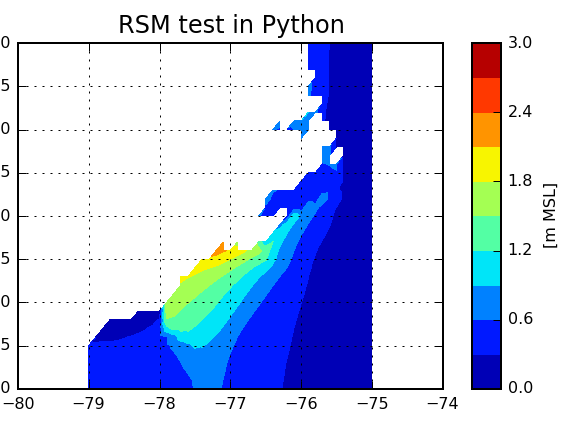

In [44]:
master(66.8,1,7.5,38,5,5)

In [41]:
#from __future__ import print_function # for python 2
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

<IPython.core.display.Javascript object>


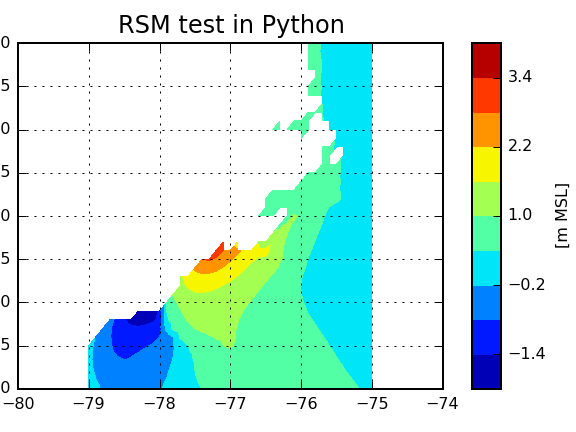

In [45]:
#rmw,H_b,TS,Vmax,LatNorth,LatSouth
interact(master, \
         rmw     =widgets.FloatSlider(min=p1min,max=p1max,step=dp1,value=rmw),\
         H_b     =widgets.FloatSlider(min=p2min,max=p2max,step=dp2,value=H_b),\
         TS      =widgets.FloatSlider(min=p3min,max=p3max,step=dp3,value=TS),\
         Vmax    =widgets.FloatSlider(min=p4min,max=p4max,step=dp4,value=Vmax),\
         LatNorth=widgets.FloatSlider(min=p5min,max=p5max,step=dp5,value=LatNorth),\
         LatSouth=widgets.FloatSlider(min=p6min,max=p6max,step=dp6,value=LatSouth))